In [1]:
pip install image_similarity_measures

     |████████████████████████████████| 19.3 MB 87.9 MB/s 
     |████████████████████████████████| 2.6 MB 62.9 MB/s 
  Created wheel for phasepack: filename=phasepack-1.5-py3-none-any.whl size=26983 sha256=eed92a655585717cb9e7fba98487db379ede66883ba16a7aef4d5b59434ff8e2
  Stored in directory: /root/.cache/pip/wheels/39/5c/b3/79292d7ac3f088e858805b5515b45cf5a365106397d936caf1
Successfully built phasepack


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Aug 16 21:54:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from keras.datasets import mnist, cifar10
from keras.models import Sequential, load_model
from keras.layers.core import Activation
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from time import time
import cv2
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, ssim, sre, issm, sam, uiq, fsim, psnr
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras import backend as K 
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(100)

In [4]:
def preprocess(dataset='mnist'):
  if (dataset == 'mnist'):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train = X_train / 255
    X_test = X_test / 255
    X_train_Flatten = X_train.reshape(len(X_train), X_train[0].shape[0]*X_train[0].shape[1])
    X_test_Flatten = X_test.reshape(len(X_test), X_train[0].shape[0]*X_train[0].shape[1])
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = np_utils.to_categorical(y_test, 10)
    y_train = np_utils.to_categorical(y_train, 10)
  else:
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train = X_train / 255
    X_test = X_test / 255
    X_train_Flatten = X_train.reshape(len(X_train), X_train[0].shape[0]*X_train[0].shape[1]*X_train[0].shape[2])
    X_test_Flatten = X_test.reshape(len(X_test), X_train[0].shape[0]*X_train[0].shape[1]*X_train[0].shape[2])
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = np_utils.to_categorical(y_test, 10)
    y_train = np_utils.to_categorical(y_train, 10)
  return (X_train, y_train), (X_test, y_test), (X_train_Flatten, X_test_Flatten)


In [58]:
def makeAndTrainModel(X_train, y_train, X_test, y_test, X_train_Flatten, X_test_Flatten, architecture, dataset):
  model = Sequential()
  datagen = ImageDataGenerator(
      horizontal_flip = True,
      #vertical_flip = True,
      width_shift_range=8/32,
      height_shift_range=8/32,
      fill_mode='nearest',
      #zoom_range=[0.60,1.40],
      #rotation_range = 90
      )
  if dataset=='cifar10':
    if architecture == 'ANN':
      model.add(Flatten()) 
      model.add(Dense(1000, input_shape = X_test_Flatten[0].shape))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.2))
      model.add(Dense(750))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.2))
      model.add(Dense(500))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.2))
      model.add(Dense(500))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.2))
      model.add(Dense(10))
      model.add(Activation('softmax'))

      opt = keras.optimizers.Adam(learning_rate=0.001)
      model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)


      checkpoint_filepath = '/tmp/checkpoint'
      model_checkpoint_callback = ModelCheckpoint(
          filepath=checkpoint_filepath,
          save_weights_only=True,
          monitor='val_accuracy',
          mode='max',
          save_best_only=True)
      
      history = model.fit(X_train_Flatten, y_train, batch_size = 32, epochs=50, validation_data=(X_test_Flatten, y_test),callbacks=[model_checkpoint_callback])
    else: # if cnn
      model.add(Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu', padding='same'))
      model.add(BatchNormalization())
      model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2, 2))) 
      model.add(Dropout(0.3)) 
      model.add(Conv2D(64, (3, 3), activation='relu', padding='same')) 
      model.add(BatchNormalization())
      model.add(Dropout(0.3)) 
      model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2, 2))) 
      model.add(Dropout(0.3)) 
      model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
      model.add(BatchNormalization())
      model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
      model.add(BatchNormalization()) 
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(Dropout(0.3)) 
      model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
      model.add(BatchNormalization())
      model.add(Flatten()) 
      model.add(Dropout(0.3)) 
      model.add(Dense(1024, activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.3)) 
      model.add(Dense(512, activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.3)) 
      model.add(Dense(10, activation='softmax'))

      #opt = keras.optimizers.Adam(learning_rate=0.001)
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      
      datagen.fit(X_train)

      checkpoint_filepath = '/tmp/checkpoint'
      model_checkpoint_callback = ModelCheckpoint(
          filepath=checkpoint_filepath,
          save_weights_only=True,
          monitor='val_accuracy',
          mode='max',
          save_best_only=True)
      
      history = model.fit(
          datagen.flow(X_train, y_train, batch_size=32),
          epochs=150,
          validation_data=(X_test, y_test), callbacks=[model_checkpoint_callback])
      
      #history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)
  else: #mnist
    if architecture == 'ANN':
      model.add(Dense(1000, input_shape = X_test_Flatten[0].shape))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.2))
      model.add(Dense(750))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.2))
      model.add(Dense(500))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.2))
      model.add(Dense(500))
      model.add(Activation('relu'))
      model.add(BatchNormalization())
      model.add(Dropout(0.2))
      model.add(Dense(10))
      model.add(Activation('softmax'))

      opt = keras.optimizers.Adam(learning_rate=0.001)
      model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
 
      history = model.fit(X_train_Flatten, y_train, batch_size = 32, epochs=10, validation_data=(X_test_Flatten, y_test)) 

    else: #cnn
      model.add(Conv2D(128, (3, 3), input_shape=(28,28,1), activation='relu'))
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2, 2))) 
      model.add(Dropout(0.2)) 
      model.add(Conv2D(64, (3, 3), activation='relu')) 
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2, 2))) 
      model.add(Dropout(0.2))
      model.add(Conv2D(32, (3, 3), activation='relu')) 
      model.add(BatchNormalization())
      model.add(MaxPooling2D(pool_size=(2, 2))) 
      model.add(Dropout(0.2)) 

      model.add(Flatten()) 
      model.add(Dense(128, activation='relu'))
      model.add(BatchNormalization()) 
      model.add(Dropout(0.2))
      model.add(Dense(64, activation='relu'))
      model.add(BatchNormalization()) 
      model.add(Dropout(0.2))
      model.add(Dense(10, activation='softmax'))

      #opt = keras.optimizers.Adam(learning_rate=0.001)
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      datagen.fit(X_train.reshape(-1, 28, 28, 1))

      checkpoint_filepath = '/tmp/checkpoint'
      model_checkpoint_callback = ModelCheckpoint(
          filepath=checkpoint_filepath,
          save_weights_only=True,
          monitor='val_accuracy',
          mode='max',
          save_best_only=True)
      
      history = model.fit(X_train.reshape(-1, 28, 28, 1), y_train, validation_data=(X_test.reshape(-1, 28, 28, 1), y_test), epochs=50, batch_size=128, callbacks=[model_checkpoint_callback])

  return model, history


In [6]:
(X_train, y_train), (X_test, y_test), (X_train_Flatten, X_test_Flatten) = preprocess('cifar10')

170508288/170498071 [==============================] - 11s 0us/step


In [ ]:
model_cifar_cnn, history_cifar_cnn = makeAndTrainModel(X_train, y_train, X_test, y_test, X_train_Flatten, X_test_Flatten, 'CNN', 'cifar10')

Epoch 1/150
1563/1563 [==============================] - 27s 16ms/step - loss: 2.2154 - accuracy: 0.2750 - val_loss: 1.8712 - val_accuracy: 0.3971
Epoch 2/150
1563/1563 [==============================] - 24s 15ms/step - loss: 1.4958 - accuracy: 0.4652 - val_loss: 1.4290 - val_accuracy: 0.5220
Epoch 3/150
1563/1563 [==============================] - 24s 15ms/step - loss: 1.2725 - accuracy: 0.5493 - val_loss: 2.0902 - val_accuracy: 0.4061
Epoch 4/150
1563/1563 [==============================] - 24s 15ms/step - loss: 1.1332 - accuracy: 0.6042 - val_loss: 1.2975 - val_accuracy: 0.5675
Epoch 5/150
1563/1563 [==============================] - 24s 15ms/step - loss: 1.0070 - accuracy: 0.6509 - val_loss: 0.9388 - val_accuracy: 0.6894
Epoch 6/150
1563/1563 [==============================] - 24s 15ms/step - loss: 0.9545 - accuracy: 0.6705 - val_loss: 0.8115 - val_accuracy: 0.7227
Epoch 7/150
1563/1563 [==============================] - 24s 15ms/step - loss: 0.8864 - accuracy: 0.6933 - val_loss: 0

In [ ]:
model_cifar_cnn.save('model_cifar_cnn.h5')

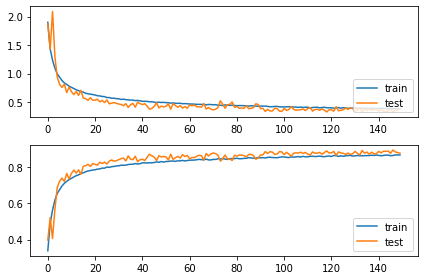

In [ ]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history_cifar_cnn.history['loss'])
plt.plot(history_cifar_cnn.history["val_loss"])
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history_cifar_cnn.history['accuracy'])
plt.plot(history_cifar_cnn.history["val_accuracy"])
plt.legend(['train', 'test'], loc='lower right')

plt.tight_layout()

In [7]:
model_cifar_ann, history_cifar_ann = makeAndTrainModel(X_train, y_train, X_test, y_test, X_train_Flatten, X_test_Flatten, 'ANN', 'cifar10')

Epoch 1/50
1563/1563 [==============================] - 36s 7ms/step - loss: 2.1766 - accuracy: 0.2733 - val_loss: 1.8745 - val_accuracy: 0.3478
Epoch 2/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7597 - accuracy: 0.3723 - val_loss: 1.7413 - val_accuracy: 0.3831
Epoch 3/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6821 - accuracy: 0.4015 - val_loss: 1.6368 - val_accuracy: 0.4292
Epoch 4/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.6278 - accuracy: 0.4167 - val_loss: 1.5785 - val_accuracy: 0.4292
Epoch 5/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.6034 - accuracy: 0.4269 - val_loss: 1.5477 - val_accuracy: 0.4434
Epoch 6/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5690 - accuracy: 0.4409 - val_loss: 1.5176 - val_accuracy: 0.4577
Epoch 7/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5514 - accuracy: 0.4414 - val_loss: 1.5524 - val_accura

In [8]:
model_cifar_ann.save('model_cifar_ann (3).h5')

In [31]:
model_cifar_ann.predict(X_test_Flatten[0].reshape(-1, 3072))

array([[0.01151147, 0.01375371, 0.01977648, 0.37340686, 0.2599521 ,
        0.13441654, 0.01718115, 0.00678583, 0.15268993, 0.01052593]],
      dtype=float32)

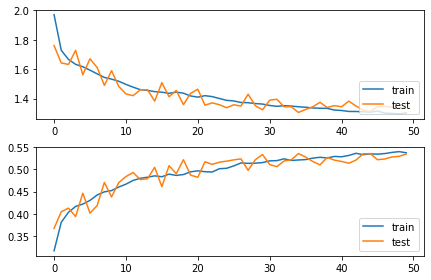

In [32]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history_cifar_ann.history['loss'])
plt.plot(history_cifar_ann.history["val_loss"])
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history_cifar_ann.history['accuracy'])
plt.plot(history_cifar_ann.history["val_accuracy"])
plt.legend(['train', 'test'], loc='lower right')

plt.tight_layout()

In [ ]:
(X_train, y_train), (X_test, y_test), (X_train_Flatten, X_test_Flatten) = preprocess('mnist')

In [ ]:
model_mnist_cnn, history_mnist_cnn = makeAndTrainModel(X_train, y_train, X_test, y_test, X_train_Flatten, X_test_Flatten, 'CNN', 'mnist')

Epoch 1/50
469/469 [==============================] - 6s 10ms/step - loss: 0.9305 - accuracy: 0.7039 - val_loss: 2.0259 - val_accuracy: 0.2963
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1619 - accuracy: 0.9499 - val_loss: 0.0645 - val_accuracy: 0.9814
Epoch 3/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1183 - accuracy: 0.9645 - val_loss: 0.0542 - val_accuracy: 0.9831
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0919 - accuracy: 0.9735 - val_loss: 0.0631 - val_accuracy: 0.9797
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0797 - accuracy: 0.9772 - val_loss: 0.0500 - val_accuracy: 0.9869
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0772 - accuracy: 0.9769 - val_loss: 0.0447 - val_accuracy: 0.9875
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0691 - accuracy: 0.9796 - val_loss: 0.0451 - val_accuracy: 0.9883
Epoch

In [ ]:
model_mnist_cnn.save('model_mnist_cnn.h5')

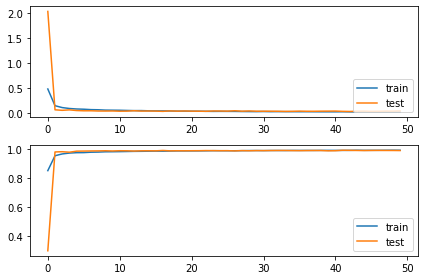

In [ ]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history_mnist_cnn.history['loss'])
plt.plot(history_mnist_cnn.history["val_loss"])
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history_mnist_cnn.history['accuracy'])
plt.plot(history_mnist_cnn.history["val_accuracy"])
plt.legend(['train', 'test'], loc='lower right')

plt.tight_layout()

In [59]:
model_mnist_ann, history_mnist_ann = makeAndTrainModel(X_train, y_train, X_test, y_test, X_train_Flatten, X_test_Flatten, 'ANN', 'mnist')

Epoch 1/10
1875/1875 [==============================] - 10s 4ms/step - loss: 0.4232 - accuracy: 0.8748 - val_loss: 0.1274 - val_accuracy: 0.9606
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1702 - accuracy: 0.9483 - val_loss: 0.1143 - val_accuracy: 0.9643
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1408 - accuracy: 0.9562 - val_loss: 0.1010 - val_accuracy: 0.9689
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1181 - accuracy: 0.9633 - val_loss: 0.0774 - val_accuracy: 0.9763
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1006 - accuracy: 0.9684 - val_loss: 0.0753 - val_accuracy: 0.9779
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0902 - accuracy: 0.9720 - val_loss: 0.0736 - val_accuracy: 0.9766
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0769 - accuracy: 0.9749 - val_loss: 0.0622 - val_accuracy

In [60]:
model_mnist_ann.save('model_mnist_ann.h5')

In [62]:
model_mnist_ann.predict(X_test_Flatten[0].reshape(-1, 784))

array([[5.3674341e-07, 6.2194572e-06, 6.9336522e-07, 2.3320265e-05,
        3.6651606e-06, 5.0722242e-06, 1.1911899e-06, 9.9994695e-01,
        2.9472112e-06, 9.4763709e-06]], dtype=float32)

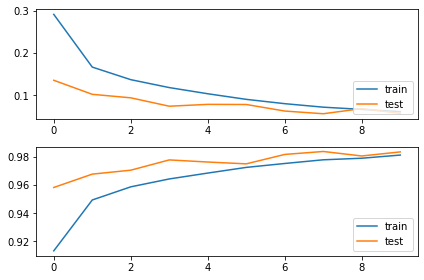

In [52]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history_mnist_ann.history['loss'])
plt.plot(history_mnist_ann.history["val_loss"])
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history_mnist_ann.history['accuracy'])
plt.plot(history_mnist_ann.history["val_accuracy"])
plt.legend(['train', 'test'], loc='lower right')

plt.tight_layout()